In [1]:
import os
import sys
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

#pre-processing of text
import string
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import pandas as pd #to work with csv files
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.svm import OneClassSVM
import plotly
from plotly import graph_objs
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

from gensim.models import Word2Vec, KeyedVectors
# Load vectors directly from the file
import gensim
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Overall goal is to handle imbalanced data.

In [2]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def clean_text(str_list, lemmatize=True):
    clean_list = []

    for text in str_list:
        # Remove pound sign from hashtags
        text = re.sub(r'#', '', text)
        # Remove URLs
        text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]*", '', text)

        words = word_tokenize(text)
        clean_words = []

        lemmatizer = WordNetLemmatizer()  # Move lemmatizer initialization outside the loop
        
        for word in words:
            # Drop words with fewer than 2 characters and drop any punctuation "words", this will also get rid of the emojis
            if len(word) > 1 and re.match(r'^\w+$', word):
                if lemmatize:
                    word = lemmatizer.lemmatize(word)  # Apply lemmatization
                clean_words.append(word)
        
        # Remove stop words
        stop_words = set(nltk.corpus.stopwords.words('english'))
        clean_words = [word for word in clean_words if word.lower() not in stop_words]
        
        clean_text = ' '.join(clean_words)
        clean_list.append(clean_text)
    
    return clean_list

In [3]:
sentence = ["I went to a birthday party"]

clean_text(sentence)

['went birthday party']

In [4]:
test_tweets = pd.read_csv('COVID19_Dataset-text_labels_only.csv')


#Filter tweets for train data (false)
false_tweets = pd.read_csv('Train.csv')
# Filter rows where the 'Origin' column is equal to 'Twitter'
false_tweets.query("label == 0")
#Changing Label to 1 to make it more consistent with the other dataset
false_tweets.loc[false_tweets['label'] == 0, 'label'] = 1

# Display the head of the datasets
print("COVID-19 Dataset:")
print(test_tweets.head())
print("\nFake News Dataset (Twitter Origin):")
print(false_tweets.head())




#Clean data 
test_tweets['clean tweet'] = clean_text(test_tweets['Tweet'])
false_tweets['clean text'] = clean_text(false_tweets['text'])

#View Data set
test_tweets.head()
false_tweets.head()



COVID-19 Dataset:
   Is_Unreliable    Category  \
0              1  1, 3, 6, 9   
1              1  1, 6, 8, 9   
2              1     1, 4, 9   
3              1        6, 8   
4              1     6, 8, 9   

                                               Tweet  
0  We are living in scary times in Canada. Gov’t ...  
1  Just as bad in Canada. In fact, our government...  
2  It was only a matter of time before the mainst...  
3  Russia's taking no chances: Foreigners infecte...  
4  Although there is now a presumptive confirmed ...  

Fake News Dataset (Twitter Origin):
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      1
1  When I put this movie in my DVD player, and sa...      1
2  Why do people who do not know what a particula...      1
3  Even though I have great interest in Biblical ...      1
4  Im a die hard Dads Army fan and nothing will e...      1


,text,label,clean text
0,I grew up (b. 1965) watching and loving the Th...,1,grew 1965 watching loving Thunderbirds mate sc...
1,"When I put this movie in my DVD player, and sa...",1,put movie DVD player sat coke chip expectation...
2,Why do people who do not know what a particula...,1,people know particular time past wa like feel ...
3,Even though I have great interest in Biblical ...,1,Even though great interest Biblical movie wa b...
4,Im a die hard Dads Army fan and nothing will e...,1,Im die hard Dads Army fan nothing ever change ...


In [5]:
import plotly
from plotly import graph_objs

In [6]:
false = len(false_tweets[false_tweets['label']== 1])
dist = [
    graph_objs.Bar(
        x=["false tweets"],
        y=[false],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Amount of False Tweets in Training Set")})

In [7]:
df = test_tweets
false = len(df[df["Is_Unreliable"] == 1])
true = len(df[df["Is_Unreliable"] == 0])
dist = [
    graph_objs.Bar(
        x=["false", "true"],
        y=[false, true],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Original: Sentiment type distribution in testing set")})

In [8]:
def create_imbalance(df, removal_count=250):
    # Shuffle the DataFrame to ensure randomness
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Get the count of tweets labeled as false
    false_count = len(df_shuffled[df_shuffled['Is_Unreliable'] == 1])
    
    # Determine the number of false tweets to remove
    remove_false_count = min(removal_count, false_count)
    
    # Remove false tweets
    removed_count = 0
    indexes_to_remove = []
    for index, row in df_shuffled.iterrows():
        if row['Is_Unreliable'] == 1:
            indexes_to_remove.append(index)
            removed_count += 1
            if removed_count >= remove_false_count:
                break
    
    df_balanced = df_shuffled.drop(indexes_to_remove)
    
    return df_balanced


In [10]:
less_false_test_data = create_imbalance(test_tweets, removal_count=250)

In [11]:
df = less_false_test_data
false = len(df[df["Is_Unreliable"] == 1])
true = len(df[df["Is_Unreliable"] == 0])
dist = [
    graph_objs.Bar(
        x=["false", "true"],
        y=[false, true],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="After: Sentiment type distribution in testing set")})

In [12]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

In [13]:
from gensim.models import Word2Vec, KeyedVectors
# Load vectors directly from the file
import gensim
import numpy as np

# Load pre-trained Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [14]:
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0
        for token in tokens:
            if token in word2vec_model:
                feat_for_this += word2vec_model[token]
                count_for_this +=1
        feats.append(feat_for_this/count_for_this)        
    return feats

In [15]:
#Now using solely false tweets
train_x = embedding_feats(false_tweets['clean text'])

#Convert to Word2Vec
#embed_x = embedding_feats(train_x)

#Dense
#dense_X = np.array(embed_x)

train_y = false_tweets['label']

In [16]:
test_X = less_false_test_data['clean tweet']
test_y = less_false_test_data['Is_Unreliable']

#Convert to Word2Vec
embed_test = embedding_feats(test_X)

#Dense
dense_test_X = np.array(embed_test)



In [17]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [18]:
one_class_svm = OneClassSVM(nu=.01, kernel = 'rbf', gamma ='auto').fit(train_x)
# nu means it allows 1% of outliers in the dataset ( we know the training data is 10% of the testing)
# maps data from a low demensional space to a high dimensional space
# gamma is a decision boundary

## Prediction by default

In [19]:
prediction = one_class_svm.predict(dense_test_X)

#Change the anomalies' values to make it consistent with the true values
prediction = [ 1 if i==-1 else 0 for i in prediction] #Changed from -1 to 1 and 1 to 0 for binary classification

#Performance
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

           0       0.88      0.35      0.50       280
           1       0.08      0.53      0.14        30

    accuracy                           0.37       310
   macro avg       0.48      0.44      0.32       310
weighted avg       0.80      0.37      0.47       310



In [20]:
#Get the scores for the testing dataset
score = one_class_svm.score_samples(dense_test_X)


#Check the score for 10% of outliers
score_threshold = np.percentile(score,1)
print(f'The customized score threshold for 1% of outliers is {score_threshold: .2f}')

The customized score threshold for 1% of outliers is  398.97


# Get a better accuracy with score_threshold
## Hyperparameters: Customize Predictions Using Scores
instead of using the default threshold for identifying outliers, we can customize the threshold and label more or fewer data points as outliers. For example, in the code below, we find the score for 1% of the data points and use it as the prediction threshold

In [21]:
#Check the model performance at 10% threshold 
customized_prediction = [0 if i > score_threshold else 1 for i in score]


#Check the prediction performance
print(classification_report(test_y, customized_prediction))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       280
           1       0.75      0.10      0.18        30

    accuracy                           0.91       310
   macro avg       0.83      0.55      0.56       310
weighted avg       0.90      0.91      0.88       310



Code referenced: https://youtu.be/O9VvmWj-JAk?si=t2xTI7RQGdDzuIAr

In [22]:
from sklearn.decomposition import PCA

X = dense_test_X

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [23]:
df = pd.DataFrame({
    'Feature 1': X_pca[:, 0],  # the first feature of dense_test_X
    'Feature 2': X_pca[:, 1],  # the second feature of dense_test_X
    'Binary Label': test_y,
    'one_class_svm_prediction': prediction,
    'one_class_svm_prediction_customized': customized_prediction
})

# Display the DataFrame
print(df)

     Feature 1  Feature 2  Binary Label  one_class_svm_prediction  \
0    -0.126024   0.105654             0                         1   
1    -0.142881   0.065603             0                         1   
4     0.002675   0.124332             0                         1   
7    -0.088191  -0.004197             0                         0   
9    -0.097154   0.105074             0                         0   
..         ...        ...           ...                       ...   
555  -0.170959  -0.103043             1                         1   
556  -0.178091  -0.117607             1                         0   
557  -0.043036   0.023733             1                         0   
558  -0.043380  -0.016942             0                         1   
559  -0.140105  -0.074618             1                         0   

     one_class_svm_prediction_customized  
0                                      0  
1                                      0  
4                                      0  

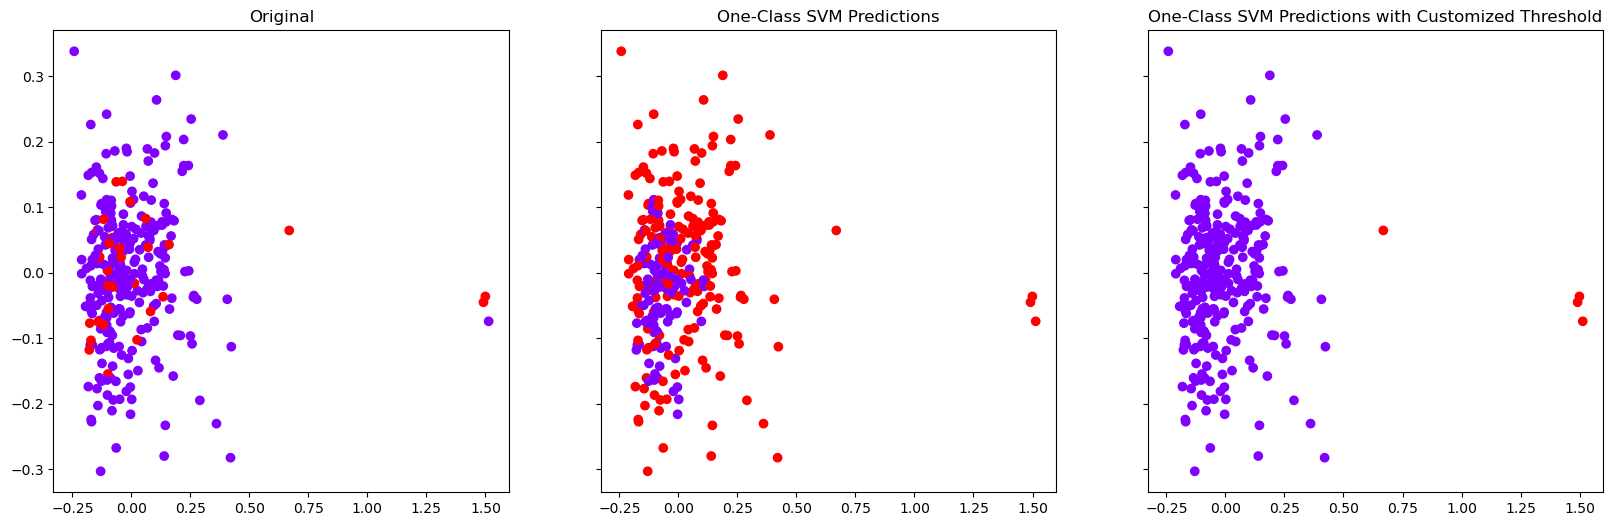

In [24]:
#Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2)= plt.subplots(1,3, sharey=True, figsize=(20,6) )

#Ground truth 
ax0.set_title('Original')
ax0.scatter(df['Feature 1'], df['Feature 2'], c=df['Binary Label'], cmap='rainbow')


#One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df['Feature 1'], df['Feature 2'], c=df['one_class_svm_prediction'], cmap='rainbow')

#One-Class SVM Predictions
ax2.set_title('One-Class SVM Predictions with Customized Threshold')
ax2.scatter(df['Feature 1'], df['Feature 2'], c=df['one_class_svm_prediction_customized'], cmap='rainbow')

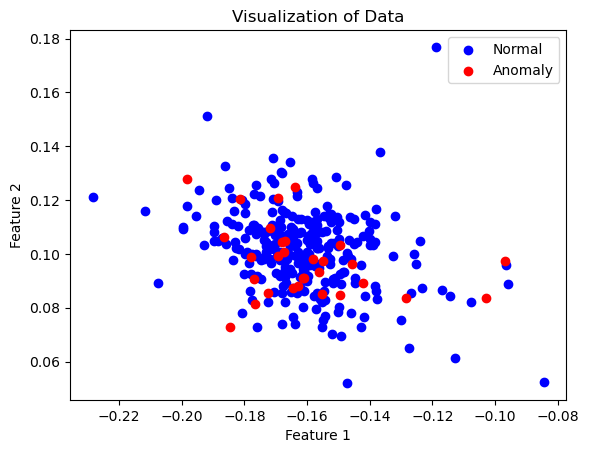

In [25]:
import matplotlib.pyplot as plt

X = dense_test_X
y = test_y
# Plot normal instances (class 0)
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', label='Normal')
# Plot anomalies (class 1)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', label='Anomaly')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Data')
plt.legend()
plt.show()


**Better Understand the Model Selection**

In [26]:
# Extract points where the first principal component >= 0.5
points_first_pc = df[df['Feature 1'] >= 0.5]

# Extract points where the second principal component >= 0.5
points_second_pc = df[df['Feature 2'] >= 0.5]

# Display the extracted points
print("Points where the first principal component >= 0.5:")
print(points_first_pc)

print("\nPoints where the second principal component >= 0.5:")
print(points_second_pc)

Points where the first principal component >= 0.5:
     Feature 1  Feature 2  Binary Label  one_class_svm_prediction  \
364   1.513453  -0.073951             0                         1   
509   1.499467  -0.035982             1                         1   
527   0.668755   0.064702             1                         1   
531   1.491553  -0.044889             1                         1   

     one_class_svm_prediction_customized  
364                                    1  
509                                    1  
527                                    1  
531                                    1  

Points where the second principal component >= 0.5:
Empty DataFrame
Columns: [Feature 1, Feature 2, Binary Label, one_class_svm_prediction, one_class_svm_prediction_customized]
Index: []


In [27]:
test_tweets = pd.read_csv('COVID19_Dataset-text_labels_only.csv')

# Accessing sentences from test_tweets
sentence_1 = test_tweets.iloc[364]
sentence_2 = test_tweets.iloc[509]
sentence_3 = test_tweets.iloc[527]
sentence_4 = test_tweets.iloc[531]

# Printing the sentences
print(sentence_1['Tweet'])
print(sentence_2['Tweet'])
print( sentence_3['Tweet'])
print(sentence_4['Tweet'])


How people are using #AI to detect and fight the #coronavirus https://t.co/YJj6kaxZZl via @VentureBeat #COVID19 #covid-19 #cloud
BC announces more cases of COVID-19. #Coronviru
'There’s a lot of fear and there’s a lot of stigma': 6 takeaways from #Mississauga town hall about #coronavirus #COVID-19
Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)


In [30]:
# Extract points where the first principal component >= 0.5
points_first_pc = df[df['Feature 1'] <= 0.25]

# Extract points where the second principal component >= 0.5
points_second_pc = df[df['Feature 2'] <= 0.25]

# Display the extracted points
print("Points where the first principal component >= 0.25:")
print(points_first_pc)

print("\nPoints where the second principal component >= 0.25:")
print(points_second_pc)

Points where the first principal component >= 0.25:
     Feature 1  Feature 2  Binary Label  one_class_svm_prediction  \
0    -0.126024   0.105654             0                         1   
1    -0.142881   0.065603             0                         1   
4     0.002675   0.124332             0                         1   
7    -0.088191  -0.004197             0                         0   
9    -0.097154   0.105074             0                         0   
..         ...        ...           ...                       ...   
555  -0.170959  -0.103043             1                         1   
556  -0.178091  -0.117607             1                         0   
557  -0.043036   0.023733             1                         0   
558  -0.043380  -0.016942             0                         1   
559  -0.140105  -0.074618             1                         0   

     one_class_svm_prediction_customized  
0                                      0  
1                                

In [31]:
test_tweets = pd.read_csv('COVID19_Dataset-text_labels_only.csv')

# Accessing sentences from test_tweets
sentence_1 = test_tweets.iloc[555]
sentence_2 = test_tweets.iloc[556]


# Printing the sentences
print(sentence_1['Tweet'])
print(sentence_2['Tweet'])


BREAKING: Harvard classes will move online starting March 23 due to a growing global coronavirus outbreak, University President
Singularity University is hosting a FREE Virtual Summit March 16-18 to share facts, answer questions, and address your concerns around COVID-19—as well as the impact of outbreaks, epidemics, and pandemics.
